# Filmaffinity scrapper

## Description

My intention is to create a scrapper from all the way up of Filmaffinity. To gather the data I'll need to make my own scrapper. Mainly, the information I want to get is the following:

From films and series:

* Title
* Year
* Running time
* Country
* Director(s)
* Screenwriter(s)
* Cast
* Cinematography
* Producer(s)
* Genre(s)
* Synopsis
* Rating
* Pro rating

From actors:

* Name
* Date of birth
* Filmography
* Awards (wins and nominations)

From reviews:

* Film
* Author number of reviews
* Author number of ratings
* Users agree with review
* Total rating average
* Date of review


## Constants

In [3]:
BASE_URL = "https://www.filmaffinity.com/es"

## Imports

In [2]:
import requests
import selenium
from bs4 import BeautifulSoup

## Tests

### Manual

First of all, what I need to do is to browse the Filmaffinity webpage in order to find from where I need to start scrapping the data.

I think the starting point should be the section "Top FA" where you can search applying different filters.

I realise that you can only select 10 different platforms to look up for films and series. However, in my opinion, this are where the vast majority of content is posted in. I've never hear 90% of names on this list.

It looks like the URL of the request needs to be something like the following:

https://www.filmaffinity.com/es/topgen.php?genres=&chv=1&orderby=rc&movietype=full%7C&country=&fromyear=1874&toyear=2025&ratingcount=0&runtimemin=0&runtimemax=7&platforms%5B%5D=8&platforms%5B%5D=119&platforms%5B%5D=1899&platforms%5B%5D=384&platforms%5B%5D=1773&platforms%5B%5D=337&platforms%5B%5D=149&platforms%5B%5D=350&platforms%5B%5D=63&platforms%5B%5D=64

At the bottom of the page we can see a little arrow to load more films:

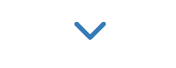

### Programmed

In [4]:
# First I make a request to the Top FA section

top_fa_request = requests.get(BASE_URL + "/topgen.php")

In [ ]:
top_fa_request.

{}